In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def filter_submissions(df):
    filt = df.groupby(level=0).size() > 1
    return df[filt[df.index.get_level_values(level=0)].values]

# Classifier columns to study
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


# Load in the acousticbrainz dataset into the variable 'acousticbrainz' (V3 also include build SHA to make sure that software
# version is the same on a commit basis.
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


- Basis variabiliteit flac over alles ipv. downsample
- Basis flac voor verschillende versies
- Barplot in lineplot audio quality
- Check oververtegenwoordiging genres in specifieke versies
- Statistisch model bitrate vs. codec vs. versie (?):
  - Literatuur lineaire en hierarchische modellen
- Acousticbrainz vast zetten op 'best case scenario' en dan nog een keer correlaties runnen
- Referencen naar github issue

In [2]:
grouped = acousticbrainz.groupby(['bit_rate', 'codec'])
grouped = grouped.progress_apply(filter_submissions)
variances = grouped[cols].groupby(level=[0,1,2]).progress_apply(get_variance)
counts = pd.DataFrame(variances.groupby(level=[0,1]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances = variances.groupby(level=[0,1]).mean()

In [8]:
grouped_only_codec = grouped
variances_only_codec = variances
counts_only_codec = counts
pooledvariances_only_codec = pooledvariances

grouped_least = acousticbrainz.groupby(['essentia_low', 'bit_rate', 'codec'])
grouped_least = grouped_least.progress_apply(filter_submissions)
variances_least = grouped_least[cols].groupby(level=[0,1,2,3]).progress_apply(get_variance)
counts_least = pd.DataFrame(variances_least.groupby(level=[0,1,2]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances_least = variances_least.groupby(level=[0,1,2]).mean()

grouped_more = acousticbrainz.groupby(['essentia_low', 'essentia_git_sha_low', 'bit_rate', 'codec'])
grouped_more = grouped_more.progress_apply(filter_submissions)
variances_more = grouped_more[cols].groupby(level=[0,1,2,3,4]).progress_apply(get_variance)
counts_more = pd.DataFrame(variances_more.groupby(level=[0,1,2,3]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances_more = variances_more.groupby(level=[0,1,2,3]).mean()

grouped_most = acousticbrainz.groupby(['essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'bit_rate', 'codec'])
grouped_most = grouped_most.progress_apply(filter_submissions)
variances_most = grouped_most[cols].groupby(level=[0,1,2,3,4,5]).progress_apply(get_variance)
counts = pd.DataFrame(variances_most.groupby(level=[0,1,2,3,4]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances = variances_most.groupby(level=[0,1,2,3,4]).mean()

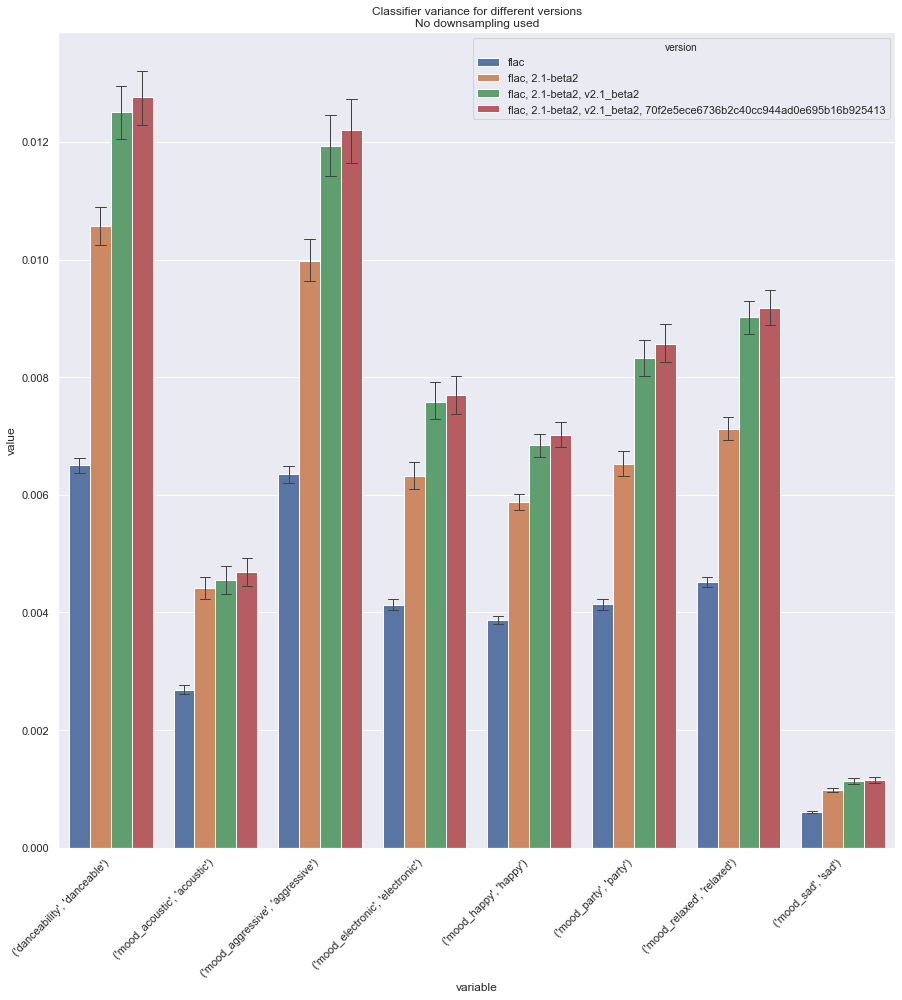

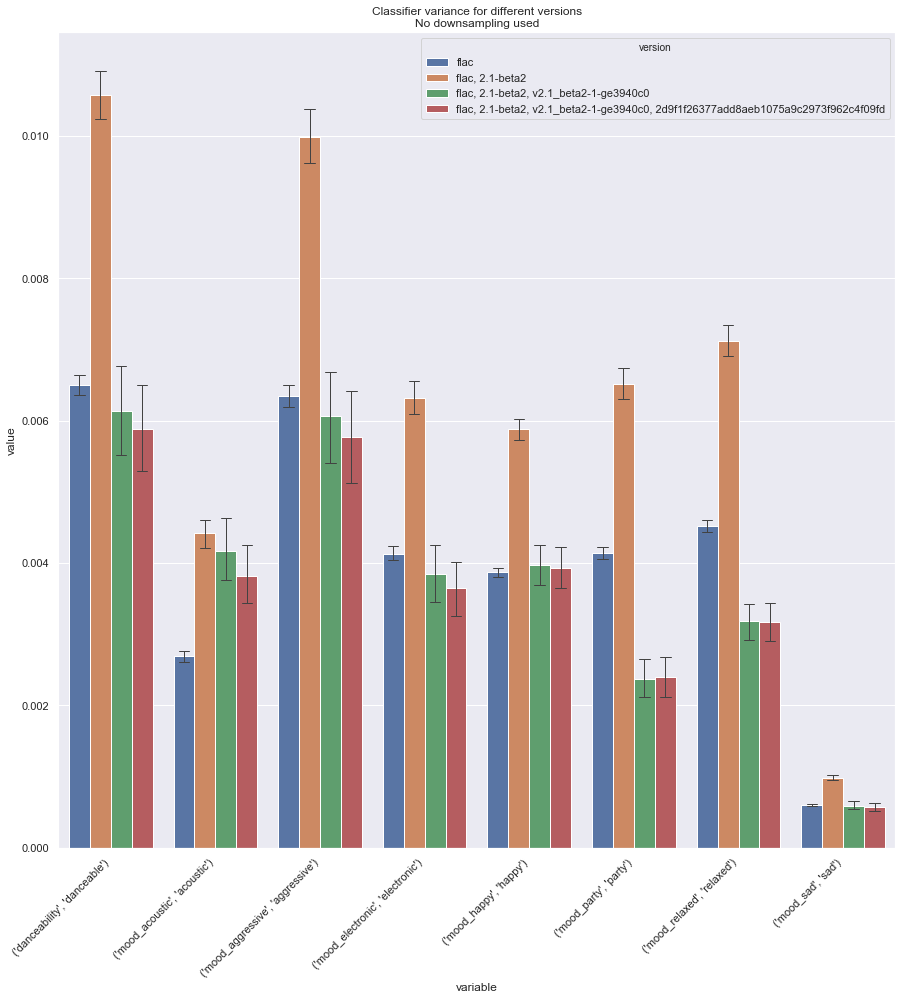

In [21]:
ver1 = ('2.1-beta2',    'v2.1_beta2',                    '70f2e5ece6736b2c40cc944ad0e695b16b925413')
ver2 = ('2.1-beta2',    'v2.1_beta2-1-ge3940c0',         '2d9f1f26377add8aeb1075a9c2973f962c4f09fd')

for ver in [ver1, ver2]:

    toplot = pd.DataFrame()

    only_codec = variances_only_codec.loc[(0, 'flac')]
    only_codec['version'] = 'flac'
    toplot = toplot.append(only_codec)

    least = variances_least.loc[(ver[0], 0, 'flac')]
    least['version'] = f"flac, {ver[0]}"
    toplot = toplot.append(least)
    
    more = variances_more.loc[(ver[0], ver[1], 0, 'flac')]
    more['version'] = f"flac, {ver[0]}, {ver[1]}"
    toplot = toplot.append(more)
    
    most = variances_most.loc[(ver[0], ver[1], ver[2], 0, 'flac')]
    most['version'] = f"flac, {ver[0]}, {ver[1]}, {ver[2]}"
    toplot = toplot.append(most)
    toplot = toplot.melt(id_vars=['version'])
    
    plt.figure()
    ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f"Classifier variance for different versions\nNo downsampling used")
    plt.show()
    
    

# Are codec stability differences actually due to the versioning?

,0
"(128000, 'mp3')",34921
"(320000, 'mp3')",23212
"(320000, 'vorbis')",5275
"(0, 'flac')",255298


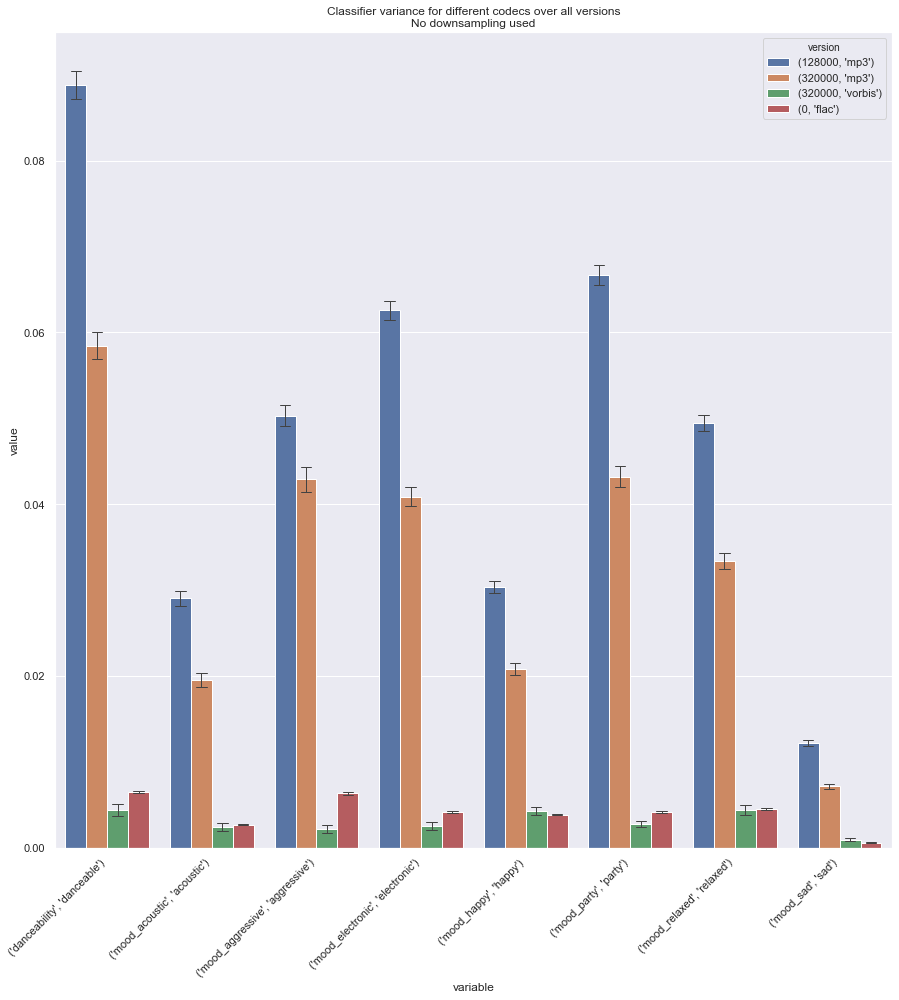

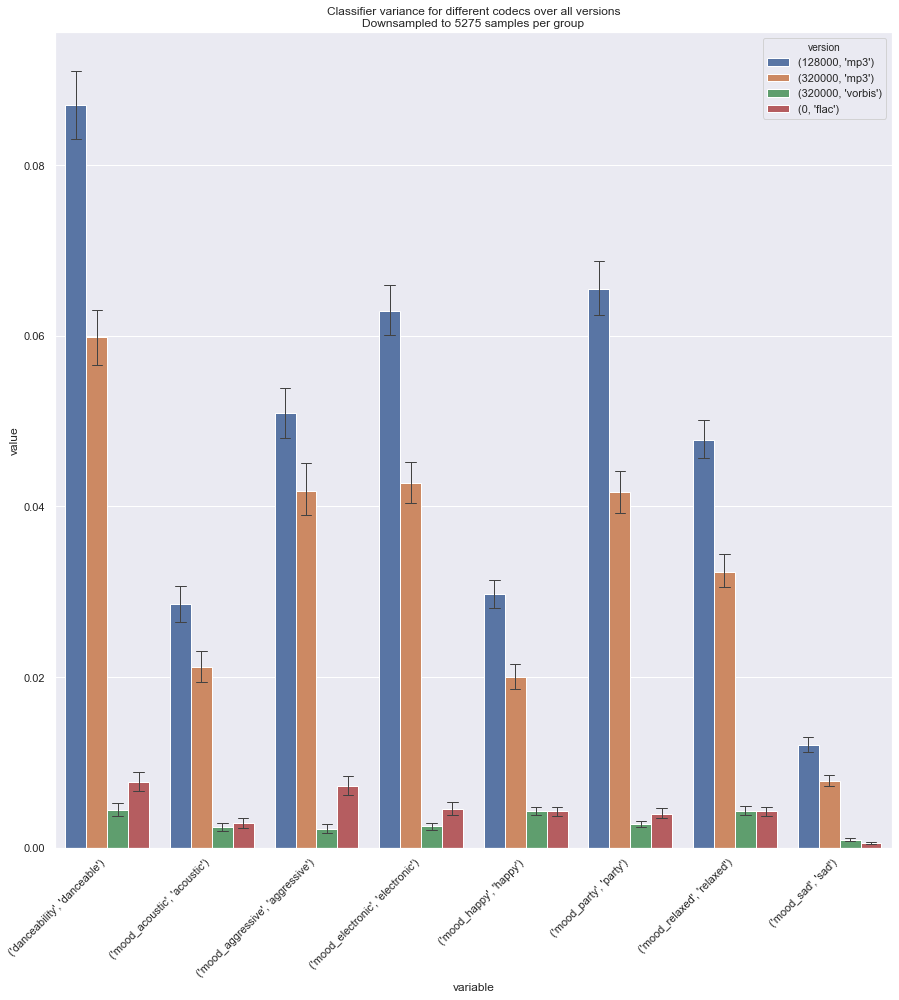

In [36]:
vers = [(128000, 'mp3'), (320000, 'mp3'), (320000, 'vorbis'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for ver in vers:
    df = variances_only_codec.loc[ver]
    df['version'] = str(ver)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(ver) for ver in vers]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['version'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over all versions\nNo downsampling used")
plt.show()


toplot = pd.DataFrame()
n_min = 20000

for ver in vers:
    df = variances_only_codec.loc[ver]
    if len(df) < n_min:
        n_min = len(df)

for ver in vers:
    df = variances_only_codec.loc[ver].sample(n_min)
    df['version'] = str(ver)
    
    toplot = toplot.append(df)
    

toplot = toplot.melt(id_vars=['version'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over all versions\nDownsampled to {n_min} samples per group")
plt.show()

#### Let's check the version distributions for these codecs

In [48]:
version_dists = pd.DataFrame()
for ver in vers:
    version_dists = version_dists.append(grouped.loc[ver]['essentia_low'].value_counts())
    
version_dists.index = vers
display(version_dists)
display(version_dists.div(version_dists.sum(axis=1), axis=0))

,2.1-beta1,2.1-beta2
"(128000, mp3)",12944.0,21977.0
"(320000, mp3)",8849.0,14363.0
"(320000, vorbis)",2.0,5273.0
"(0, flac)",130699.0,124599.0


,2.1-beta1,2.1-beta2
"(128000, mp3)",0.370665,0.629335
"(320000, mp3)",0.381225,0.618775
"(320000, vorbis)",0.000379,0.999621
"(0, flac)",0.511947,0.488053


So yes and no? mp3 had same distribution, but difference for at least the bitrate.
Vorbis is way more stable, but this could just be due to the distribution skew towards 2.1-beta2

If vorbis is low due to the version, is there a specific sha that is very prominent there?

In [53]:
tocheck = grouped.loc[(320000, 'vorbis')]
display(tocheck['essentia_git_sha_low'].value_counts())
display(tocheck['essentia_build_sha_low'].value_counts())

v2.1_beta2-1-ge3940c0          5116
v2.1_beta2-2-gbb40004           157
v2.1_beta1-7-ge0e83e8-dirty       2
Name: essentia_git_sha_low, dtype: int64

cead25079874084f62182a551b7393616cd33d87    5116
c0e182ba78c2de26e491b7b7a4a2c98c1ed34208     157
12879b851c9f4b0d899e1af4e221aa110f283a84       2
Name: essentia_build_sha_low, dtype: int64

Is **(v2.1_beta2-1-ge3940c0, cead25079874084f62182a551b7393616cd33d87)** the magical combination? Let's filter on specifically this version and look at the codec differences again:

,0
"(128000, 'mp3')",243
"(320000, 'mp3')",100
"(320000, 'vorbis')",5006
"(0, 'flac')",317


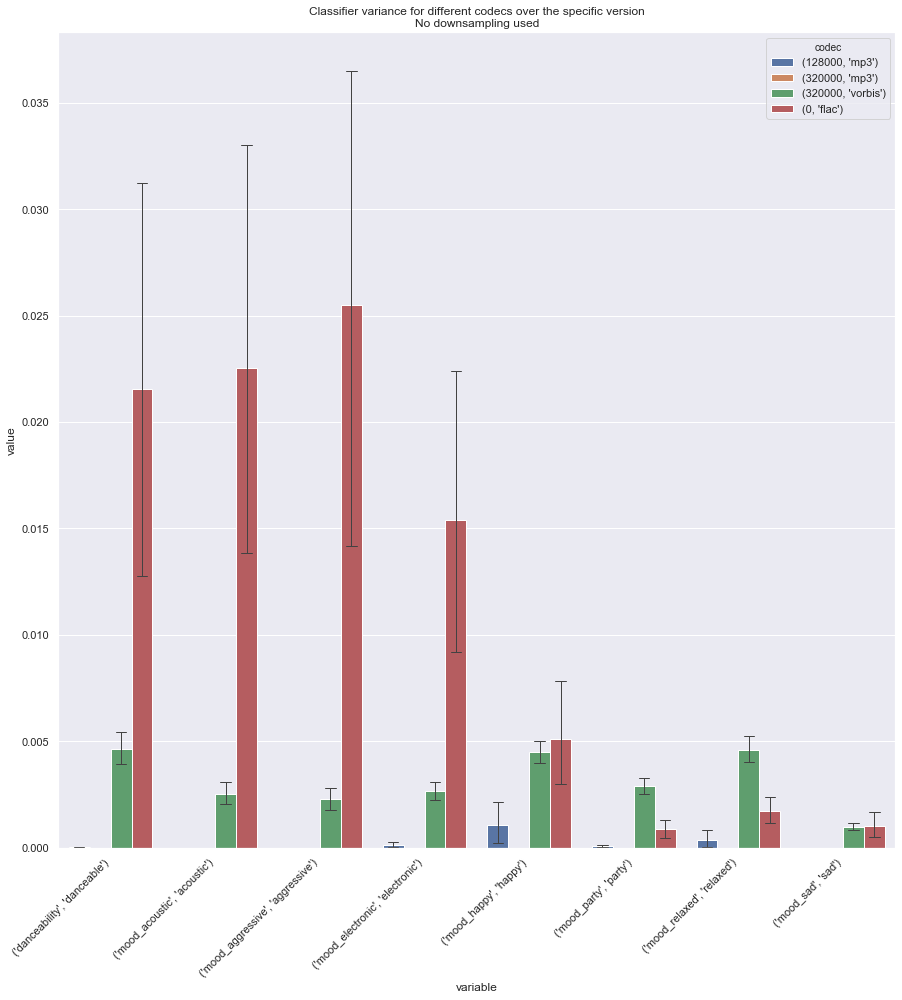

In [55]:
magic_ver = ('2.1-beta2', 'v2.1_beta2-1-ge3940c0', 'cead25079874084f62182a551b7393616cd33d87')
codecs = [(128000, 'mp3'), (320000, 'mp3'), (320000, 'vorbis'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for codec in codecs:
    df = variances_most.loc[(magic_ver[0], magic_ver[1], magic_ver[2], codec[0], codec[1])]
    df['codec'] = str(codec)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(codec) for codec in codecs]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['codec'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='codec', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over the specific version\nNo downsampling used")
plt.show()

And if we exclude the build sha to increase sample sizes?

,0
"(128000, 'mp3')",10055
"(320000, 'mp3')",8119
"(320000, 'vorbis')",5006
"(0, 'flac')",18279


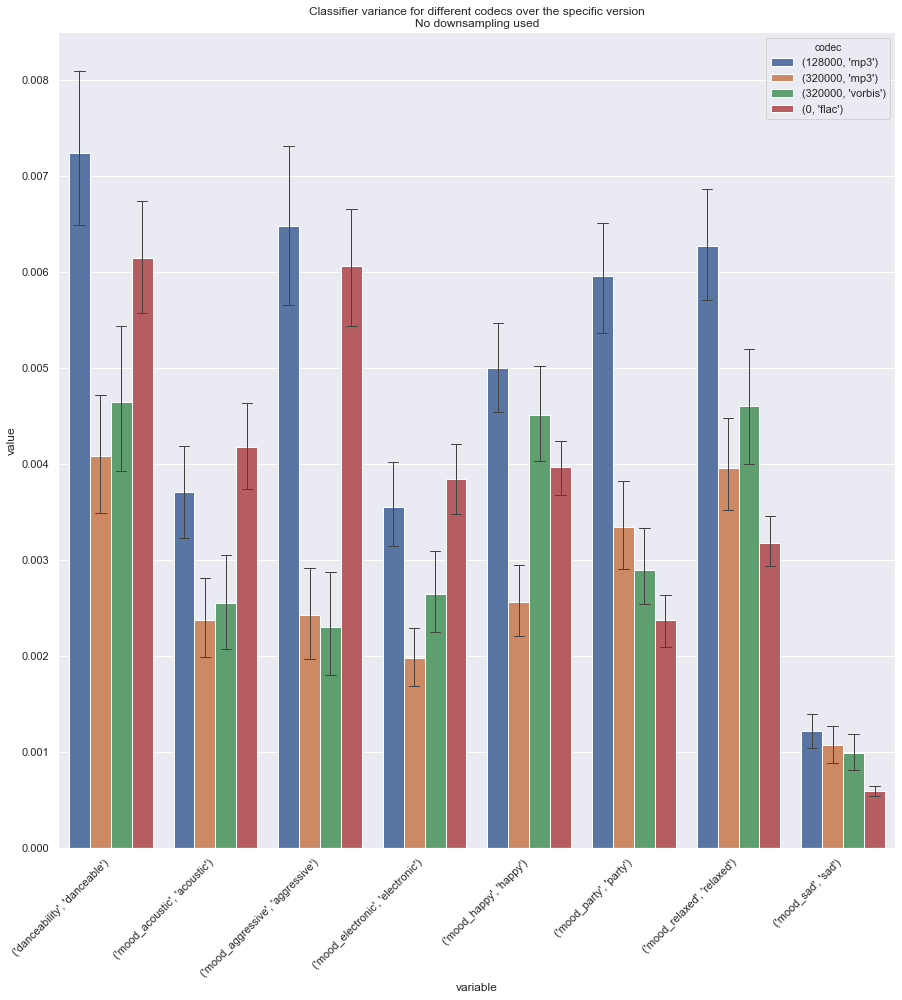

In [56]:
magic_ver = ('2.1-beta2', 'v2.1_beta2-1-ge3940c0')
codecs = [(128000, 'mp3'), (320000, 'mp3'), (320000, 'vorbis'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for codec in codecs:
    df = variances_more.loc[(magic_ver[0], magic_ver[1], codec[0], codec[1])]
    df['codec'] = str(codec)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(codec) for codec in codecs]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['codec'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='codec', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over the specific version\nNo downsampling used")
plt.show()

**v2.1_beta2-1-ge3940c0** has much better stability, let's investigate what we can find...

In the 'do it yourself install' section: https://acousticbrainz.org/download this is the build that is used as the **win 32 bit extractor static binary**

The same page lists another git sha for the mac extractor, which is **64-bit**: **v2.1_beta2-2-gbb40004**, let's check stabilities when filtering on this one:

,0
"(128000, 'mp3')",444
"(320000, 'mp3')",325
"(320000, 'vorbis')",18
"(0, 'flac')",966


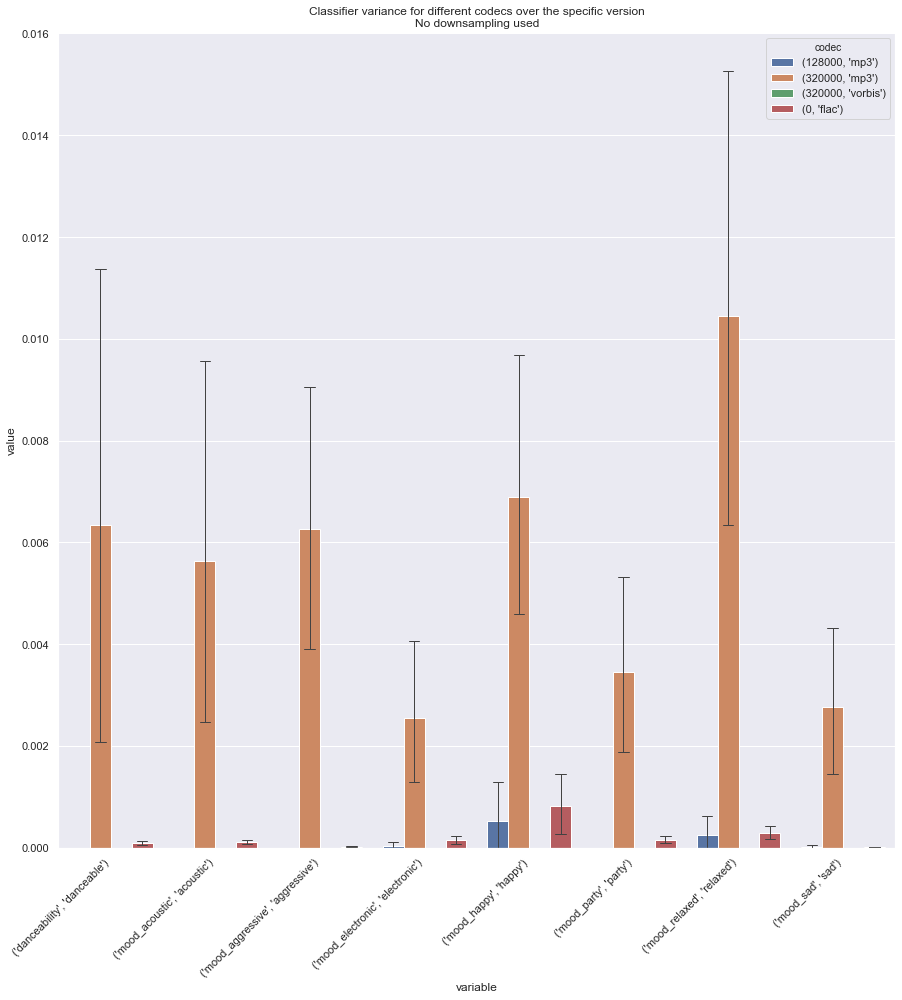

In [63]:
magic_ver = ('2.1-beta2', 'v2.1_beta2-2-gbb40004')
codecs = [(128000, 'mp3'), (320000, 'mp3'), (320000, 'vorbis'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for codec in codecs:
    df = variances_more.loc[(magic_ver[0], magic_ver[1], codec[0], codec[1])]
    df['codec'] = str(codec)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(codec) for codec in codecs]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['codec'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='codec', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over the specific version\nNo downsampling used")
plt.show()

This one also seems relatively low, then where do the other version numbers come from? the FAQ on acousticbrainz lists:

Q: Why does AcousticBrainz prefer that people use the provided static extractor builds, rather than letting others build their own versions?

A: Besides building your own version being a major pain, it is possible for different combinations of libraries and compilers (gcc vs clang, libffmpeg vs libav) to produce slightly different outputs. We're aiming to reduce the variances of output between the extractors in an effort to create the most consistent and stable dataset. We're going to build a test suite in the future that can evaluate the performance of a compiled extractor, but we're not quite there yet. So, for the time being, if it is possible in any way for you to use one of our static builds, we would greatly appreciate that.

The second most used version in the data is:

In [66]:
grouped_only_codec['essentia_git_sha_low'].value_counts()

v2.1_beta2-1-ge3940c0            157464
v2.1_beta2                       111800
v2.1_beta1-28-g21ef5f4-dirty      77973
v2.1_beta1-28-g21ef5f4            40977
v2.1_beta1-6-g5578087             31665
v2.1_beta1-7-ge0e83e8-dirty       16163
v2.1_beta1-34-gf95df8b             9772
v2.1_beta2-2-gbb40004              8781
v2.1_beta1-5-gf9dded9              6374
v2.1_beta1-7-ge0e83e8              6370
v2.1_beta1-217-g9cf4dbf-dirty      3276
v2.1_beta1-6-g5578087-dirty        1702
v2.1_beta1-8-g0ed32f5-dirty        1317
v2.1_beta1-13-g0c62dac-dirty       1042
v2.1_beta2-15-g8ccb801              496
v2.1_beta1-19-g7eb2c36              366
v2.1_beta2-3-gd5e3a6e               238
v2.1_beta1-3-gbee56e8               198
v2.1_beta1-16-gb6b8370              181
v2.1_beta1-26-g48277d2               92
v2.1_beta1-219-gaf871ae              57
v2.1_beta1-16-g023b2af               43
v2.1_beta1-9-geaa627a                42
v2.1_beta1-16-gcc947d7               28
v2.1_beta2-12-g91c6a07               16


,0
"(128000, 'mp3')",3300
"(320000, 'mp3')",2544
"(0, 'flac')",22359


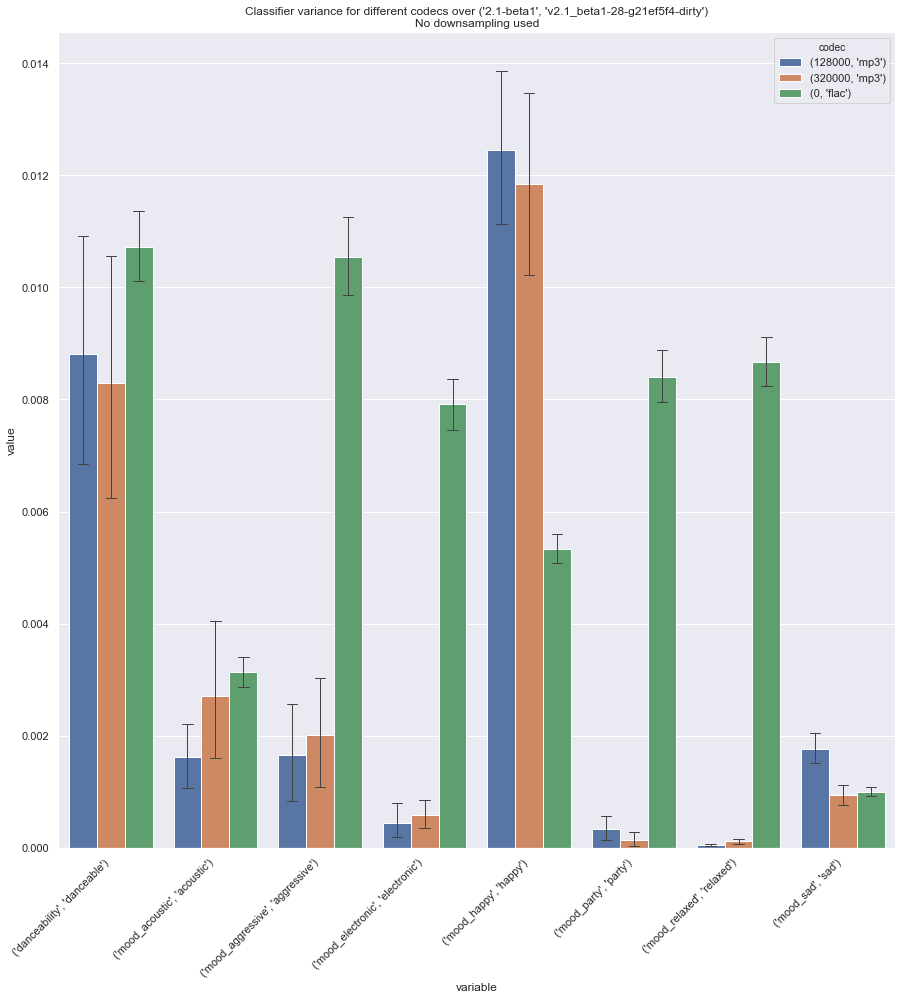

In [80]:
magic_ver = ('2.1-beta1', 'v2.1_beta1-28-g21ef5f4-dirty')
codecs = [(128000, 'mp3'), (320000, 'mp3'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for codec in codecs:
    df = variances_more.loc[(magic_ver[0], magic_ver[1], codec[0], codec[1])]
    df['codec'] = str(codec)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(codec) for codec in codecs]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['codec'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='codec', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over {magic_ver}\nNo downsampling used")
plt.show()

,0
"(128000, 'mp3')",200
"(320000, 'mp3')",28
"(0, 'flac')",2642


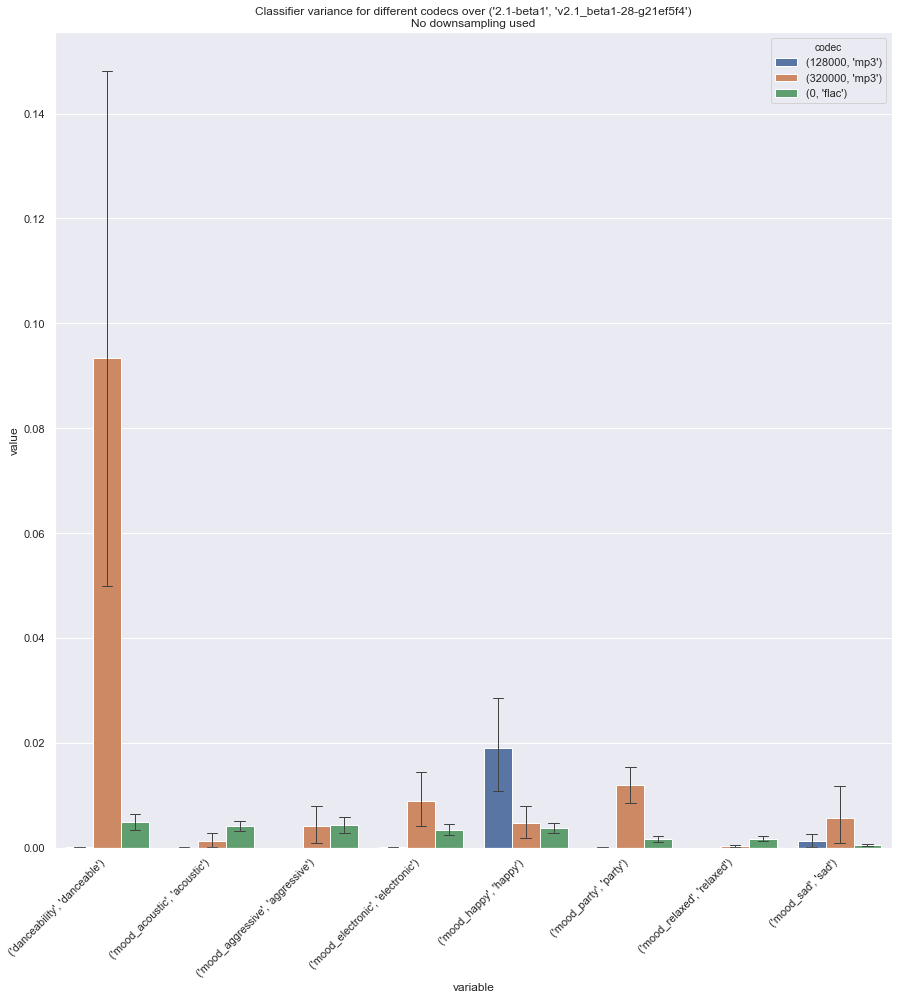

In [83]:
magic_ver = ('2.1-beta1', 'v2.1_beta1-28-g21ef5f4')
codecs = [(128000, 'mp3'), (320000, 'mp3'), (0, 'flac')]
toplot = pd.DataFrame()
samplesizes = []

for codec in codecs:
    df = variances_more.loc[(magic_ver[0], magic_ver[1], codec[0], codec[1])]
    df['codec'] = str(codec)
    
    toplot = toplot.append(df)
    samplesizes.append(len(df))

indexes = [str(codec) for codec in codecs]
samplesizes = pd.DataFrame(samplesizes)
samplesizes.index = indexes
display(samplesizes)
    

toplot = toplot.melt(id_vars=['codec'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='codec', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different codecs over {magic_ver}\nNo downsampling used")
plt.show()

This is the version mentioned in this issue: https://github.com/MTG/essentia/issues/179